In [6]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            plt.plot(self.S[n, :], 'g')
            if not axis_on:
                plt.axis('off')

iteration: 1, error: 8.041117775221519
iteration: 100, error: 0.014001455184664145
iteration: 200, error: 5.319255372093459e-05
iteration: 300, error: 4.1986837204864856e-05
iteration: 400, error: 3.3205401551547924e-05
iteration: 431, error: 2.0841059715701563e-06
ymin: 0.8, ymax: 10.2


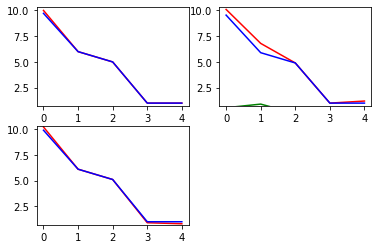

array([[9.7186942 , 5.9999996 , 5.0000006 , 0.99999886, 0.99999887],
       [9.5467338 , 5.89676449, 4.9000006 , 0.99990917, 0.99990919],
       [9.88632917, 6.09999975, 5.09999909, 0.9962485 , 0.99624852]])

In [9]:
import numpy as np

# D = np.array([ [10, 6, 5, 1, 1], [10, 1, 3, 2, 2],[0 , 5,2,-1.1, -1.2],[0, 5,2,-1.15, -1.22]])
D = np.array([ [10, 6, 5, 1, 1], [10.1, 6.8, 4.9, 1, 1.2],[10.2, 6.1, 5.1, 0.9, 0.8]])
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)
# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()
L

In [92]:
import numpy as np
import pandas as pd

#G = pd.read_csv('data.csv')
G = pd.read_csv('image.csv')
#M = np.array([ [[6], [5], [1]], [[1], [3], [2]],[[5],[2],[1]]])
N = np.squeeze(np.asarray(G))
rpca = R_pca(N)
L, E = rpca.fit(max_iter=10000, iter_print=100)
df = pd.DataFrame(L)
df.to_csv('Lim.csv', index = False)
df = pd.DataFrame(E)
df.to_csv('Eim.csv', index = False)

iteration: 1, error: 0.12005476137674989
iteration: 100, error: 0.0005028409380395438
iteration: 200, error: 0.00026452856100309634
iteration: 300, error: 0.00012910725406405579
iteration: 400, error: 3.9278570388056434e-05
iteration: 490, error: 1.0083130121804924e-05


In [4]:
import numpy as np
import pandas as pd

#G = pd.read_csv('data.csv')
# G = pd.read_csv('image.csv')
G = pd.read_csv('data.csv')
#M = np.array([ [[6], [5], [1]], [[1], [3], [2]],[[5],[2],[1]]])
N = np.squeeze(np.asarray(G))
rpca = R_pca(N)
L, E = rpca.fit(max_iter=10000, iter_print=100)
df = pd.DataFrame(L)
df.to_csv('L.csv', index = False)
df = pd.DataFrame(E)
df.to_csv('E.csv', index = False)
#print ('L = ', L)
#print ('E = ', E)
#print ('M = ', L+E )

iteration: 1, error: 0.0833860070841239
iteration: 100, error: 0.00022806257253852553
iteration: 200, error: 0.000238309104282226
iteration: 300, error: 0.00021443866316753007
iteration: 400, error: 0.00021105674394879265
iteration: 432, error: 0.00019314818189955269
